In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import ants
import matplotlib.pyplot as plt
import seaborn as sns

from src.improved_padding import ImprovedPadding
from src.utils import get_mask, compute_js_divergence, compute_kl_divergence, detect_outliers

import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [5]:
dir_hd = Path("/media/maichi/T7")
list_patients = (dir_hd / "list_patients.txt").read_text().split("\n")
list_patients = [list_patients[i] for i in np.argsort([int(patient.strip("AIDREAM_")) for patient in list_patients if patient.startswith("AIDREAM_")])]
print("Nbr of patients: ", len(list_patients))
list_patients = list_patients

list_biomarkers = ["CTH", "rCBV", "OEF", "rCMRO2", "Delay", "rLeakage", "COV"]
list_interpolators = ["linear", "bSpline", "lanczosWindowedSinc", "nearestNeighbor", "genericLabel"]



Nbr of patients:  186


In [6]:
# register biomarkers for all patients, using different interpolation methods :
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    for biomarker in list_biomarkers:
        for interpolator in list_interpolators:

            print(fr"Registering {biomarker} for patient={patient}, interpolator={interpolator}")
            padder.register(biomarker, interpolator=interpolator)


Processing patient 1/186 : AIDREAM_1
Registering CTH for patient=AIDREAM_1, interpolator=linear
Registering CTH for patient=AIDREAM_1, interpolator=bSpline
Registering CTH for patient=AIDREAM_1, interpolator=lanczosWindowedSinc
Registering CTH for patient=AIDREAM_1, interpolator=nearestNeighbor
Registering CTH for patient=AIDREAM_1, interpolator=genericLabel
Registering rCBV for patient=AIDREAM_1, interpolator=linear
Registering rCBV for patient=AIDREAM_1, interpolator=bSpline
Registering rCBV for patient=AIDREAM_1, interpolator=lanczosWindowedSinc
Registering rCBV for patient=AIDREAM_1, interpolator=nearestNeighbor
Registering rCBV for patient=AIDREAM_1, interpolator=genericLabel
Registering OEF for patient=AIDREAM_1, interpolator=linear
Registering OEF for patient=AIDREAM_1, interpolator=bSpline
Registering OEF for patient=AIDREAM_1, interpolator=lanczosWindowedSinc
Registering OEF for patient=AIDREAM_1, interpolator=nearestNeighbor
Registering OEF for patient=AIDREAM_1, interpolator

In [4]:
# Register the brainmask for all patients, using genericLabel interpolation:
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    print(fr"Registering brainmask for patient={patient}, interpolator=genericLabel")
    padder.register("brainmask", interpolator="genericLabel")


Processing patient 1/186 : AIDREAM_1
Registering brainmask for patient=AIDREAM_1, interpolator=genericLabel
Processing patient 2/186 : AIDREAM_2
Registering brainmask for patient=AIDREAM_2, interpolator=genericLabel
Processing patient 3/186 : AIDREAM_3
Registering brainmask for patient=AIDREAM_3, interpolator=genericLabel
Processing patient 4/186 : AIDREAM_4
Registering brainmask for patient=AIDREAM_4, interpolator=genericLabel
Processing patient 5/186 : AIDREAM_6
Registering brainmask for patient=AIDREAM_6, interpolator=genericLabel
Processing patient 6/186 : AIDREAM_7
Registering brainmask for patient=AIDREAM_7, interpolator=genericLabel
Processing patient 7/186 : AIDREAM_9
Registering brainmask for patient=AIDREAM_9, interpolator=genericLabel
Processing patient 8/186 : AIDREAM_10
Registering brainmask for patient=AIDREAM_10, interpolator=genericLabel
Processing patient 9/186 : AIDREAM_11
Registering brainmask for patient=AIDREAM_11, interpolator=genericLabel
Processing patient 10/18

In [5]:
# Resample the brainmask for all patients, using genericLabel interpolation :
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    print(fr"Resampling brainmask for patient={patient}, interpolator=genericLabel")
    padder.register("brainmask", interpolator="genericLabel")


Processing patient 1/186 : AIDREAM_1
Resampling brainmask for patient=AIDREAM_1, interpolator=genericLabel
Processing patient 2/186 : AIDREAM_2
Resampling brainmask for patient=AIDREAM_2, interpolator=genericLabel
Processing patient 3/186 : AIDREAM_3
Resampling brainmask for patient=AIDREAM_3, interpolator=genericLabel
Processing patient 4/186 : AIDREAM_4
Resampling brainmask for patient=AIDREAM_4, interpolator=genericLabel
Processing patient 5/186 : AIDREAM_6
Resampling brainmask for patient=AIDREAM_6, interpolator=genericLabel
Processing patient 6/186 : AIDREAM_7
Resampling brainmask for patient=AIDREAM_7, interpolator=genericLabel
Processing patient 7/186 : AIDREAM_9
Resampling brainmask for patient=AIDREAM_9, interpolator=genericLabel
Processing patient 8/186 : AIDREAM_10
Resampling brainmask for patient=AIDREAM_10, interpolator=genericLabel
Processing patient 9/186 : AIDREAM_11
Resampling brainmask for patient=AIDREAM_11, interpolator=genericLabel
Processing patient 10/186 : AIDRE

In [6]:
def get_pct(image):
    mask_image = get_mask(image.numpy())
    values = image[mask_image == 1].flatten()
    return np.mean(values) * 100

path_results = Path.cwd().parent / "data" / "brainmask_coverage.csv"
if path_results.exists():
    df_brainmask_coverage = pd.read_csv(str(path_results))
else:

    df_brainmask_coverage = pd.DataFrame(columns=["patient", "brainmask", "brainmask_resampled", "brainmask_registered"])

    # Compare the percentage of non-zero voxels in the brainmask for all patients :
    for i, patient in enumerate(list_patients):

        print(f"Processing patient {i+1}/{len(list_patients)} : {patient}")
        padder = ImprovedPadding(patient)

        # Load the GT brainmask:
        brainmask = padder.get_biomarker("brainmask")
        pct_gt = get_pct(brainmask)

        # Load the resampled brainmask:
        brainmask_resampled = padder.get_resampled_biomarker("brainmask", interpolator="genericLabel")
        pct_resampled = get_pct(brainmask_resampled)

        # Load the registered brainmask:
        brainmask_registered = padder.get_atlas_biomarker("brainmask", interpolator="genericLabel")
        pct_registered = get_pct(brainmask_registered)

        # Compute the percentage of non-zero voxels :
        df_brainmask_coverage.loc[len(df_brainmask_coverage)] = [patient, pct_gt, pct_resampled, pct_registered]

    df_brainmask_coverage.to_csv(path_results, index=False)


In [7]:
df_brainmask_coverage["diff_resampled"] = np.abs(df_brainmask_coverage["brainmask"] - df_brainmask_coverage["brainmask_resampled"])
df_brainmask_coverage["diff_registered"] = np.abs(df_brainmask_coverage["brainmask"] - df_brainmask_coverage["brainmask_registered"])

In [8]:
df_brainmask_coverage.sort_values(by="diff_registered", ascending=False)

,patient,brainmask,brainmask_resampled,brainmask_registered,diff_resampled,diff_registered
120,AIDREAM_232,0.966755,0.968031,0.948981,0.001275,0.017775
138,AIDREAM_314,0.942059,0.945956,0.927870,0.003897,0.014190
161,AIDREAM_358,0.937219,0.934330,0.923237,0.002889,0.013982
79,AIDREAM_113,0.797743,0.801595,0.810667,0.003852,0.012924
88,AIDREAM_124,0.936295,0.939623,0.923384,0.003328,0.012912
...,...,...,...,...,...,...
63,AIDREAM_90,0.968146,0.968891,0.967840,0.000745,0.000307
154,AIDREAM_344,0.962453,0.965292,0.962653,0.002839,0.000200
160,AIDREAM_357,0.934821,0.937173,0.934627,0.002351,0.000194
150,AIDREAM_332,0.921690,0.924258,0.921643,0.002568,0.000048


In [9]:
def get_histogram(image: np.ndarray, p, bins = None) -> np.ndarray:

    mask_image = get_mask(image)
    image_values = image[mask_image == 1].flatten()
    image_values = np.round(image_values, p)

    if bins is None:
        bin_width = 10**-p
        min_val = np.floor(np.min(image_values) / bin_width) * bin_width
        max_val = np.ceil(np.max(image_values) / bin_width) * bin_width
        bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Compute the histogram :
    hist_image, bins_image = np.histogram(image_values, bins=bins, density=True)

    return hist_image, bins_image


In [10]:
# Compute the KL divergence between the ground truth and the resampled CTH, and between the ground truth and the atlas CTH :
# And compare the KL divergence with the ground truth for both resampled and non-resampled images :
path_results = Path.cwd().parent / "data" / "kl_divergence_CTH_interpolators.csv"

if path_results.exists():
    df_kl_divergence = pd.read_csv(str(path_results))
else:
    df_kl_divergence = pd.DataFrame(columns=["patient", "interpolator", "KL divergence resampled", "KL divergence registered"])

    for i, patient in enumerate(list_patients):

        print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
        padder = ImprovedPadding(patient)

        # Load the ground truth cth :
        cth = padder.get_biomarker("CTH").numpy()
        brainmask = padder.get_biomarker("brainmask", interpolator="genericLabel").numpy()
        cth = cth * brainmask

        # load the resampled brainmask :
        resampled_brainmask = padder.get_resampled_biomarker("brainmask", interpolator="genericLabel").numpy()
        # load the registered brainmask :
        registered_brainmask = padder.get_atlas_biomarker("brainmask", interpolator="genericLabel").numpy()

        for interpolator in list_interpolators:
            print(f"patient={patient}, interpolator={interpolator}")

            padder = ImprovedPadding(patient)
            # Load the resampled CTH and the registered CTH :
            resampled_cth = padder.get_resampled_biomarker("CTH", interpolator=interpolator).numpy()
            if interpolator not in ["nearestNeighbor", "genericLabel"]:
                resampled_cth = resampled_cth * resampled_brainmask

            registered_cth = padder.get_atlas_biomarker("CTH", interpolator=interpolator).numpy()
            if interpolator not in ["nearestNeighbor", "genericLabel"]:
                registered_cth = registered_cth * registered_brainmask

            # Compute the histograms :
            hist_cth, bins_cth = get_histogram(cth, p=2, bins=100)
            hist_resampled_cth, _ = get_histogram(resampled_cth, p=2, bins=bins_cth)
            hist_registered_cth, _ = get_histogram(registered_cth, p=2, bins=bins_cth)

            # Compute the KL divergence between the Ground truth CTH and the resampled CTH :
            kl_divergence_resampled = compute_kl_divergence(hist_cth, hist_resampled_cth)
            # Compute the KL divergence between the Ground truth CTH and the registered CTH :
            kl_divergence_registered = compute_kl_divergence(hist_cth, hist_registered_cth)

            df_kl_divergence.loc[len(df_kl_divergence)] = [patient, interpolator, kl_divergence_resampled, kl_divergence_registered]

    df_kl_divergence.to_csv(str(path_results), index=False)


In [18]:
# Determine the outliers :
print("95% quantile for KL divergence registered : ", df_kl_divergence["KL divergence registered"].quantile(0.95))

df_outliers, lower_bound, upper_bound = detect_outliers(df_kl_divergence, "KL divergence registered", lower_bound=0, upper_bound=0.15)
outliers = set(df_outliers["patient"])
print(f"Outliers based on KL divergence registered : {outliers}")


95% quantile for KL divergence registered :  0.0769873656242442
Outliers based on KL divergence registered : {'AIDREAM_228', 'AIDREAM_152', 'AIDREAM_310', 'AIDREAM_20'}


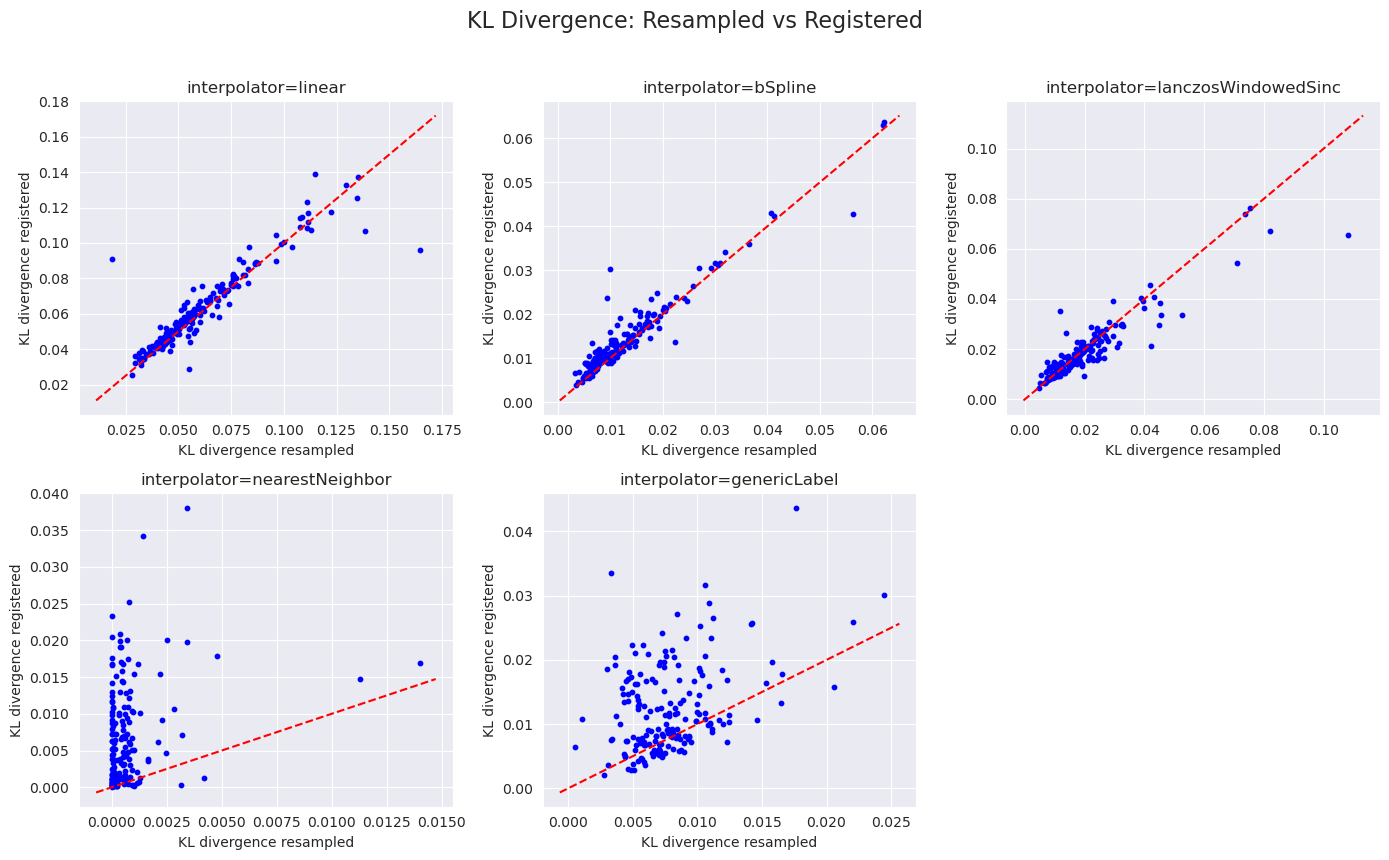

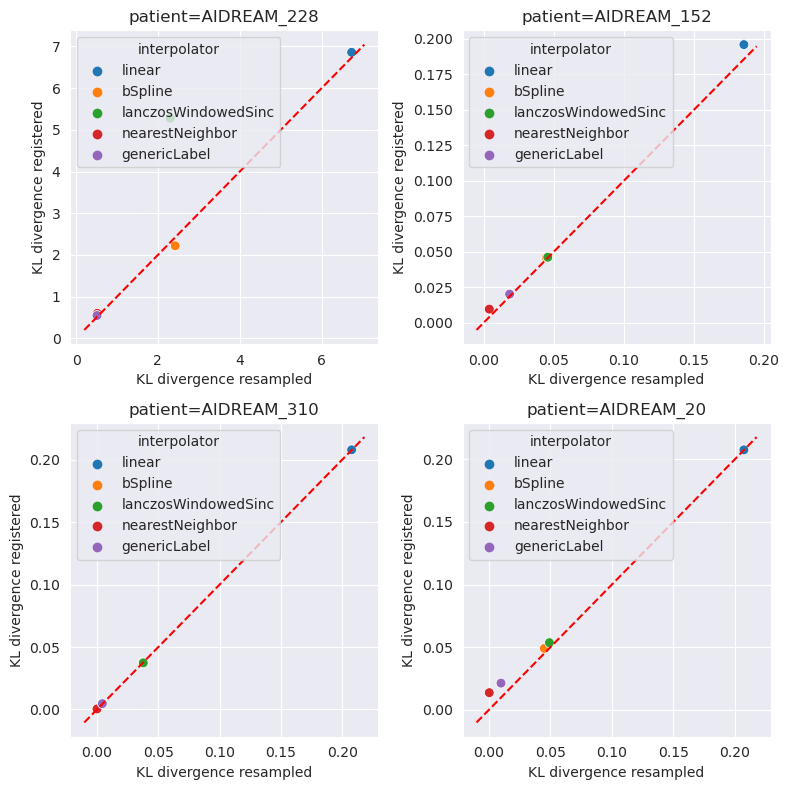

In [20]:
# Scatter the patients per interpolator, based on KL divergence resampled and KL divergence non-resampled (CTH):

# Create the figure
fig = plt.figure(figsize=(14, 9))
fig.suptitle("KL Divergence: Resampled vs Registered", fontsize=16, y=0.95)

for idx, interpolator in enumerate(list_interpolators):

    df_interpolator = df_kl_divergence.loc[df_kl_divergence["interpolator"] == interpolator]
    df_no_outliers = df_interpolator.loc[~df_interpolator["patient"].isin(outliers)]

    ax = fig.add_subplot(2, 3, idx+1)
    ax.scatter(df_no_outliers["KL divergence resampled"], df_no_outliers["KL divergence registered"], s=10, c="blue")
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], "--", c="red")

    ax.set_xlabel("KL divergence resampled")
    ax.set_ylabel("KL divergence registered")
    ax.set_title(f"interpolator={interpolator}")

# Adjust layout for readability
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Plot the outliers :
n_rows = int(np.ceil(np.sqrt(len(outliers))))
fig = plt.figure(figsize=(4 * n_rows, 4 * n_rows))

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, patient in enumerate(outliers):

    ax = fig.add_subplot(n_rows, n_rows, i+1)
    _df = df_kl_divergence.loc[df_kl_divergence["patient"] == patient]

    scatter = sns.scatterplot(data=_df, x="KL divergence resampled", y="KL divergence registered", ax=ax,
                              s=50, hue="interpolator", palette="tab10")

    ax.set_title(f"patient={patient}")
    ax.plot(ax.get_xlim(), ax.get_xlim(), "--", c="red")

plt.tight_layout()  # Adjust layout to make space for the legend
plt.show()


In [21]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='red', marker=None,
            linestyle='--', linewidth=1.0)

In [22]:
cols = ["patient", "interpolator", "KL divergence registered"]
df_no_outliers = df_kl_divergence[cols].loc[~df_kl_divergence["patient"].isin(outliers)].copy()
df_no_outliers.groupby("interpolator").describe()


KL divergence registered                                \
                                       count      mean       std       min   
interpolator                                                                 
bSpline                                182.0  0.014278  0.008906  0.003863   
genericLabel                           182.0  0.012428  0.006821  0.002090   
lanczosWindowedSinc                    182.0  0.018779  0.011295  0.004646   
linear                                 182.0  0.063556  0.022864  0.025583   
nearestNeighbor                        182.0  0.006603  0.006826  0.000066   

                                                             
                          25%       50%       75%       max  
interpolator                                                 
bSpline              0.009057  0.011554  0.016756  0.063708  
genericLabel         0.007452  0.010697  0.016675  0.043716  
lanczosWindowedSinc  0.012491  0.015729  0.021725  0.076412  
linear               0.047546  0.057582  0.075214  0.139005  
nearestNeighbor      0.001188  0.004340  0.010152  0.038064

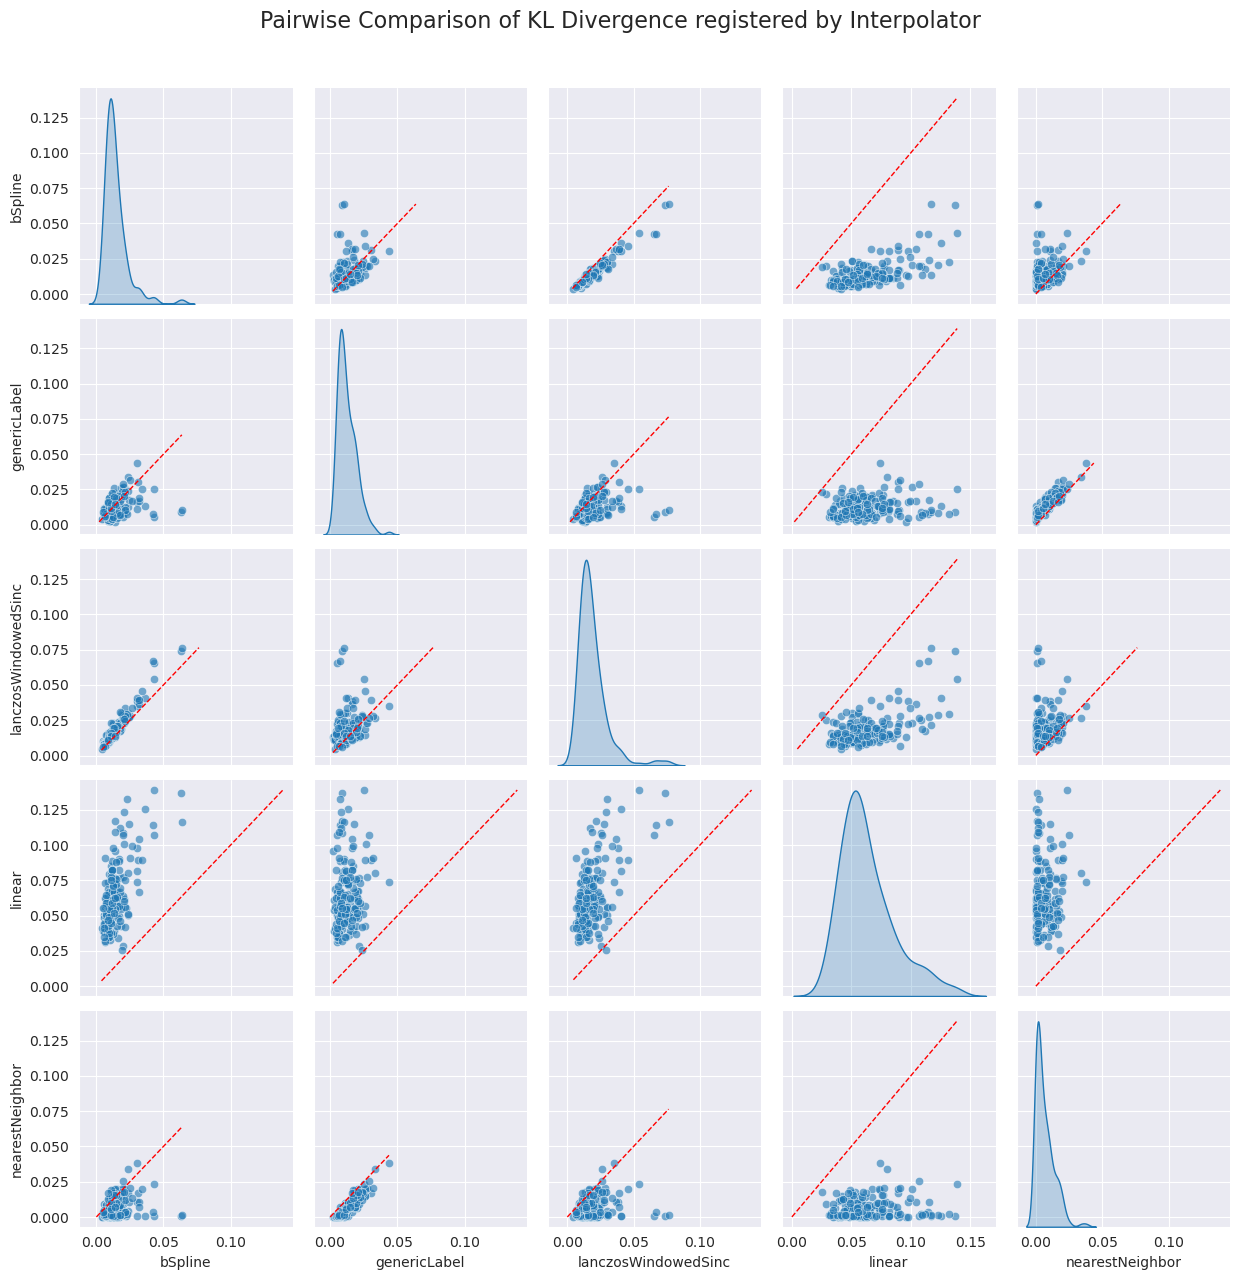

In [23]:
# Prepare the data for pairwise comparisons
df_pairwise = df_no_outliers.pivot(
    index="patient", columns="interpolator", values="KL divergence registered"
).reset_index()

# Plot the pairplot with KDE on the diagonal
pairplot = sns.pairplot(
    df_pairwise,
    diag_kind="kde",  # Kernel density plot on the diagonal
    kind="scatter",   # Scatter plot for pairwise relationships
    plot_kws={"alpha": 0.6},  # Transparency for scatter points
    diag_kws={"fill": True}  # Fill the diagonal density plots
)

pairplot.map_offdiag(plot_unity)

# Add a title to the entire plot
plt.suptitle("Pairwise Comparison of KL Divergence registered by Interpolator", y=1.02, fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [24]:
df_outliers

,patient,interpolator,KL divergence resampled,KL divergence registered
80,AIDREAM_20,linear,0.207192,0.207364
530,AIDREAM_152,linear,0.185690,0.195989
585,AIDREAM_228,linear,6.733821,6.860235
586,AIDREAM_228,bSpline,2.421900,2.219061
587,AIDREAM_228,lanczosWindowedSinc,2.302375,5.278432
588,AIDREAM_228,nearestNeighbor,0.517186,0.598883
589,AIDREAM_228,genericLabel,0.511191,0.546616
675,AIDREAM_310,linear,0.207749,0.207954


In [52]:
# Understanding the patient AIDREAM_228 :
patient = "AIDREAM_228"

padder = ImprovedPadding(patient)

# Load the ground truth cth :
cth = padder.get_biomarker("CTH")
hist_cth, bins_cth = get_histogram(cth.numpy(), p=2, bins=100)

# T1 spacing :
t1 = padder.get_t1()

# Load the resampled cth, and its brainmask :
resampled_cth = padder.get_resampled_biomarker("CTH", interpolator="linear")
hist_resampled_cth, _ = get_histogram(resampled_cth.numpy(), p=2, bins=bins_cth)


# resample cth using ANTs :
ants_resampled_cth = ants.resample_image(cth, resampled_cth.spacing, interp_type=0)
hist_ants_resampled_cth, _ = get_histogram(ants_resampled_cth.numpy(), p=2, bins=bins_cth)


In [40]:
print(fr"KL divergence between CTH and resampled CTH : {compute_kl_divergence(hist_cth, hist_resampled_cth)}")
print(fr"KL divergence between CTH and ANTs resampled CTH : {compute_kl_divergence(hist_cth, hist_ants_resampled_cth)}")

KL divergence between CTH and resampled CTH : 6.777893956444874
KL divergence between CTH and ANTs resampled CTH : 6.408903175074349


In [57]:
df_kl_divergence.loc[df_kl_divergence["interpolator"] == "linear"].sort_values(by="KL divergence registered", ascending=True)

,patient,interpolator,KL divergence resampled,KL divergence registered
805,AIDREAM_358,linear,0.028044,0.025583
580,AIDREAM_227,linear,0.055182,0.028656
400,AIDREAM_114,linear,0.032428,0.031024
920,AIDREAM_394,linear,0.029490,0.032325
615,AIDREAM_238,linear,0.032290,0.032889
...,...,...,...,...
845,AIDREAM_366,linear,0.114841,0.139005
530,AIDREAM_152,linear,0.185690,0.195989
80,AIDREAM_20,linear,0.207192,0.207364
675,AIDREAM_310,linear,0.207749,0.207954


In [59]:
len(bins_cth)

101